In [57]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
from sklearn.manifold import TSNE
from sparse2coarse import sparse2coarse
from cifar100coarse import CIFAR100Coarse

## How well do the latent representations of a VQ-VAE correlate with the labels of annotated images?##

Files already downloaded and verified
Files already downloaded and verified
50000 10000
torch.Size([3, 32, 32])


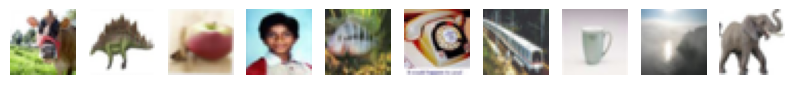

In [58]:
#transforms
transform = transforms.Compose([
    transforms.ToTensor(),  #to tensor
    # transforms.Normalize((0.5,), (0.5,))  #normalize
])

#dataset split
train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_dataset), len(test_dataset)) #50K, 10K
print(train_dataset[0][0].shape) #3X32X32

#print a few images from the dataset
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(train_dataset[i][0].permute(1, 2, 0))
    ax[i].axis('off')
plt.show()

In [60]:
testset_data = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
trainset_data = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
testset_data.targets = sparse2coarse(testset_data.targets)
trainset_data.targets = sparse2coarse(trainset_data.targets)
testset = CIFAR100Coarse(root='./data', train=False, transform=transform, download=False)
trainset = CIFAR100Coarse(root='./data', train=True, transform=transform, download=False)
testset_loader = DataLoader(testset, batch_size=64, shuffle=False)
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=False)
print(testset_loader.dataset.targets)
print(trainset_loader.dataset.targets)

Files already downloaded and verified
Files already downloaded and verified
[10 10  0 ...  4  8  2]
[11 15  4 ...  8  7  1]


In [63]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()

        self.num_embeddings = num_embeddings #number of vectors in codebook
        self.embedding_dim = embedding_dim #dimension of each vector
        self.commitment_cost = commitment_cost #beta term

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

    def forward(self, inputs):
        #BCHW -> BHWC
        # inputs = inputs.permute(0, 2, 3, 1).contiguous()
        # print(inputs.shape)
        inputs_flatten = inputs.view(-1, self.embedding_dim) #flatten input tensor
        
        #finding closest codebook vectors
        distances = (torch.sum(inputs_flatten ** 2, dim=1, keepdim=True) +
                     torch.sum(self.embeddings.weight ** 2, dim=1) -
                     2 * torch.matmul(inputs_flatten, self.embeddings.weight.t()))
        
        #closest embedding indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        #one-hot indices -. new representation
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        #quantize
        #multiplying one-hot indices with codebook vectors
        quantized = torch.matmul(encodings, self.embeddings.weight).view(inputs.shape)

        #losses
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()  #something for backprop
        
        return quantized, loss, encoding_indices

In [64]:
##simple encoder
class Encoder(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=64, num_classes=20):
        super(Encoder, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, in_channels*32*32)
        self.conv1 = nn.Conv2d(in_channels*2, 32, kernel_size=4, stride=2, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, embedding_dim, kernel_size=3, stride=1, padding=1)  
        
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.norm3 = nn.BatchNorm2d(128)

    def forward(self, x, labels):
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.view(-1, 3, 32, 32)
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.norm1(self.conv1(x)))
        x = F.leaky_relu(self.norm2(self.conv2(x)))
        x = F.leaky_relu(self.norm3(self.conv3(x)))
        x = self.conv4(x)  

        return x


##simple decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim=64, out_channels=3, num_classes=20):
        super(Decoder, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.conv1 = nn.ConvTranspose2d(embedding_dim, 64, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  
        self.conv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)  

    def forward(self, x, labels):
        # label_embed = self.label_embedding(labels)
        # label_embed = label_embed.view(-1, 3, 32, 32)
        # x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))  #-1,1 output

        return x

In [65]:
##put together
class VQVAE(nn.Module):
    def __init__(self, embedding_dim=64, num_embeddings=512):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def forward(self, x, labels):

        z = self.encoder(x, labels)
        quantized, vq_loss, _ = self.quantizer(z)
        x_recon = self.decoder(quantized, labels)

        return x_recon, vq_loss

In [66]:
##training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_vqvae(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            recon, vq_loss = model(images, labels)
            recon_loss = F.mse_loss(recon, images)
            loss = recon_loss + vq_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

train_vqvae(model, trainset_loader, epochs=10)

Epoch 1, Loss: 2.5433
Epoch 2, Loss: 0.0964
Epoch 3, Loss: 0.0884
Epoch 4, Loss: 0.0901
Epoch 5, Loss: 0.0936
Epoch 6, Loss: 0.0950
Epoch 7, Loss: 0.0943
Epoch 8, Loss: 0.0936
Epoch 9, Loss: 0.0926
Epoch 10, Loss: 0.0912


In [67]:
#extract latent representations and labels
def extract_latent_codes(model, dataloader):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            z = model.encoder(images, targets)
            quantized, _, _ = model.quantizer(z)

            pooled_latents = quantized.mean(dim=[2, 3])
            # print(pooled_latents.shape)
            latents.append(pooled_latents.cpu())
            labels.append(targets)
            
    return torch.cat(latents), torch.cat(labels)

In [68]:
##small nn to classify latents
class LatentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LatentClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        
        self.fc6 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        
        return x

In [70]:
#extract
train_latents, train_labels = extract_latent_codes(model, trainset_loader)
test_latents, test_labels = extract_latent_codes(model, testset_loader)

print(f"Latent shape train: {train_latents.shape}")
print(f"Labels: {train_labels.shape}")

print(f"Latent shape test: {test_latents.shape}")
print(f"Labels: {test_labels.shape}")

Latent shape train: torch.Size([50000, 64])
Labels: torch.Size([50000])
Latent shape test: torch.Size([10000, 64])
Labels: torch.Size([10000])


In [71]:
#latents dataset
train_dataset_lat = torch.utils.data.TensorDataset(train_latents, train_labels)
test_dataset_lat = torch.utils.data.TensorDataset(test_latents, test_labels)

train_loader_lat = DataLoader(train_dataset_lat, batch_size=64, shuffle=True)
test_loader_lat = DataLoader(test_dataset_lat, batch_size=64, shuffle=False)

In [72]:
##train classifier
latent_dim = train_latents.shape[1] 
num_classes = 20
classifier = LatentClassifier(latent_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_classifier(model, dataloader, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for latents, labels in dataloader:
            latents, labels = latents.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(latents)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

train_classifier(classifier, train_loader_lat, epochs=50)


Epoch 1, Loss: 2.6084
Epoch 2, Loss: 2.4790
Epoch 3, Loss: 2.4427
Epoch 4, Loss: 2.4111
Epoch 5, Loss: 2.3932
Epoch 6, Loss: 2.3748
Epoch 7, Loss: 2.3646
Epoch 8, Loss: 2.3505
Epoch 9, Loss: 2.3421
Epoch 10, Loss: 2.3286
Epoch 11, Loss: 2.2881
Epoch 12, Loss: 2.2769
Epoch 13, Loss: 2.2668
Epoch 14, Loss: 2.2656
Epoch 15, Loss: 2.2616
Epoch 16, Loss: 2.2571
Epoch 17, Loss: 2.2531
Epoch 18, Loss: 2.2512
Epoch 19, Loss: 2.2503
Epoch 20, Loss: 2.2471
Epoch 21, Loss: 2.2399
Epoch 22, Loss: 2.2390
Epoch 23, Loss: 2.2406
Epoch 24, Loss: 2.2368
Epoch 25, Loss: 2.2362
Epoch 26, Loss: 2.2386
Epoch 27, Loss: 2.2360
Epoch 28, Loss: 2.2343
Epoch 29, Loss: 2.2337
Epoch 30, Loss: 2.2377
Epoch 31, Loss: 2.2379
Epoch 32, Loss: 2.2368
Epoch 33, Loss: 2.2323
Epoch 34, Loss: 2.2359
Epoch 35, Loss: 2.2344
Epoch 36, Loss: 2.2349
Epoch 37, Loss: 2.2358
Epoch 38, Loss: 2.2362
Epoch 39, Loss: 2.2343
Epoch 40, Loss: 2.2374
Epoch 41, Loss: 2.2315
Epoch 42, Loss: 2.2364
Epoch 43, Loss: 2.2334
Epoch 44, Loss: 2.23

In [74]:
##evaluate
def evaluate_classifier(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for latents, labels in dataloader:
            latents, labels = latents.to(device), labels.to(device)
            outputs = model(latents)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

accuracy = evaluate_classifier(classifier, test_loader_lat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 30.35%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14120962..0.9981147].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698266..0.9984718].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25023878..0.9970616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24298489..0.9986902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35957018..0.99996716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28687596..0.99705637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

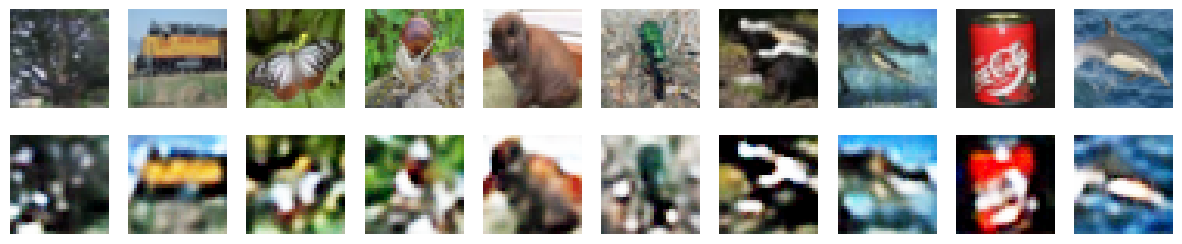

In [8]:
#make some reconstructions
#put them back into rgb space
def reconstruct_images(model, test_loader, device, num_images=10):
    model.eval()
    for images, labels in test_loader:
        

        latents = model.encoder(images, labels)
        reconstructed_images = model.decoder(latents, labels)
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 3))

    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().detach().numpy().transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].cpu().detach().numpy().transpose(1, 2, 0))
        axes[1, i].axis('off')
    
    plt.show()

reconstruct_images(model, test_loader, device)

In [ ]:
#reconstruction mse
def compute_mse(model, test_loader, device):
    model.eval()
    total_mse = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            # Get the reconstructed output from the model
            reconstructed = model.decoder(model.encoder(data, labels), labels)
            
            # Compute Mean Squared Error (MSE) between original and reconstructed image
            mse = F.mse_loss(reconstructed, data)
            total_mse += mse.item()
    
    avg_mse = total_mse / len(test_loader)
    print(f"Average MSE: {avg_mse:.4f}")
    return avg_mse

# Call the function to compute MSE
compute_mse(model, test_loader, device)

Average MSE: 0.0648


0.0647749898919634

In [ ]:
#reconstructiuon ssim
def compute_ssim(model, test_loader, device):
    model.eval()
    total_ssim = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            reconstructed = model.decoder(model.encoder(data, labels), labels)
            
            data_np = data.cpu().numpy()
            reconstructed_np = reconstructed.cpu().numpy()
            
            batch_ssim = 0
            for i in range(data.size(0)):  
                batch_ssim += ssim(data_np[i, 0], reconstructed_np[i, 0], data_range=1)
            
            total_ssim += batch_ssim / data.size(0)
    
    avg_ssim = total_ssim / len(test_loader)
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_ssim

compute_ssim(model, test_loader, device)


Average SSIM: 0.5975


np.float64(0.5974809993196819)

In [55]:
testset_data = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
testset_data.targets = sparse2coarse(testset_data.targets)
testset = CIFAR100Coarse(root='./data', train=False, transform=transform, download=False)
testset_loader = DataLoader(testset, batch_size=64, shuffle=False)
print(testset_loader.dataset.targets)



Files already downloaded and verified
[10 10  0 ...  4  8  2]


19


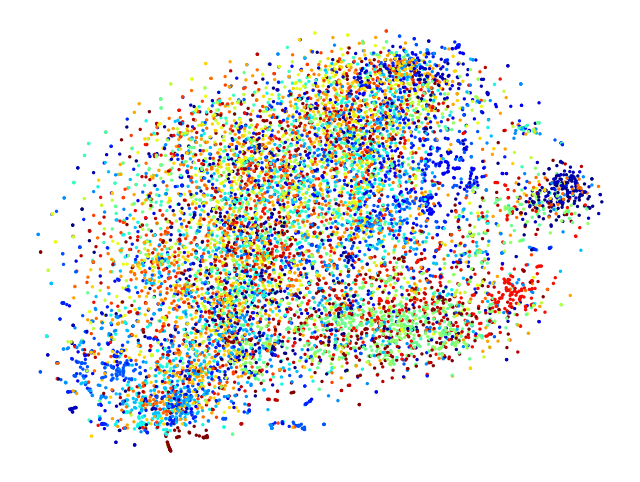

In [75]:
#visualize latent space
def visualize_latent_space(model, data_loader, device):
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            
            latent_representation = model.encoder(data, target)
            latents.append(latent_representation.view(latent_representation.size(0), -1).cpu().numpy())
            labels.append(target.cpu().numpy())
    
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(max(labels))
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='jet', s=2)
    # plt.colorbar(scatter)
    plt.axis('off')
    plt.show()

visualize_latent_space(model, testset_loader, device)